# <center> Neural Networks and Deep Learning (CSCI 5922)</center>
# <center> Spring 2020 </center>

**Name:** David Young-Jae Kim

## Goal

The goal of this assignment is to introduce neural networks in terms of ideas you are already familiar with:  linear regression and classification

## Dataset

You are given a dataset with 2 input variables ($x_1$, $x_2$) and an output variable ($y$).

In [1]:
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import numpy as np
import os
from numpy.linalg import inv

# Load data
data = np.loadtxt(os.path.join('data', 'assign1_data.txt'),  delimiter=',')
X = data[:,:2]
X=np.append(X, np.resize(np.ones(len(X)+1),(-1,1)), axis=1)
y = data[:, 2]
z = data[:, 3]

## Part 1

Write a program to find the exact least squares solution to $y = w_1 x_1 + w_2 x_2 + b$ for the above dataset, using the normal equation.

Complete the following function below and use it to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given function.

In [2]:
def least_squares(X, y):
    """
    Finds the Least Squares solution
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of output value 'y' (size : no of examples X 1)
    
    Returns
    -------
    w : solution array
    """
    return np.matmul(np.matmul(inv(np.matmul(X.T,X)),X.T),y)
    #pass

(A) Report the values of $w_1$, $w_2$, and $b$.

In [3]:
w=least_squares(X,y)

print("The values of w1 is",w[0],"w2 is",w[1],"and the bias is",w[2])

The values of w1 is -2.044242595137635 w2 is 3.996860168659326 and the bias is -0.9242908118675917


(B) What function or method did you use to find the least-squares solution?

In this problem we approched it using the general linear regression, we used the equation
$$\beta = (X^TX)^{-1}X^Ty$$

## Part 2

Implement linear regression of y on X via first-order optimization of the least-squares objective. Write a program that determines the coefficients {w1,w2,b}. Implement stochastic gradient descent, batch gradient descent, and mini-batch gradient descent. You will need to experiment with updating rules, step sizes (i.e. learning rates), stopping criteria, etc. Experiment to find settings that lead to solutions with the fewest number of sweeps through the data.

Complete the following functions below and use them to answer questions (A), (B) and (C). You may find the shuffle function from scikit-learn useful. 

Use the following hyperparameters:

Learning rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]

MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]

**Note:** Please do not change the interface of the given functions.

In [4]:
from sklearn.utils import shuffle

# function that returns a TRUE value if the error difference is smaller than a certain error rate
def error_difference(before_error,current_error):
    if before_error == 0:
        return False
    error_rate = 0.0001
    return abs(current_error - before_error) / before_error <= error_rate

# function to compute hypothesis / predictions 
def predictions(X, w): 
    return np.dot(X, w) 
  
# function to compute gradient of error function w.r.t. weight w 
def gradient(X, y, w): 
    grad = np.dot(X.T, (predictions(X, w) - y)) 
    return grad 
  
# function to compute the error for current values of weight w
def R(X, y, w):
    return (1/len(y))*((predictions(X,w) - y)**2).sum()

def online_epoch(X, y, w, alpha):
    """
    One epoch of stochastic gradient descent (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    error = 0
    
    for i in range(len(y)):
        w = w - alpha * (np.dot(w,X[i]) - y[i]) * X[i]
        error += R(X, y, w)
    
    error /= len(y)
    
    return error, w
    #pass

def batch_update(X, y, w, alpha):
    """
    One iteration of full-batch gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    w = w - alpha * (1/len(y)) * gradient(X, y, w)
    
    return R(X, y, w), w 
    #pass

def mini_batch_update(X, y, w, alpha, batch_size):
    """
    One epoch of mini-batch SGD over the entire dataset (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    batch_size : size of the batch for gradient update
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    batch_error = 0
    for i in range(0, len(y), batch_size):
        if i+batch_size < len(y):
            error, w = batch_update(X[i:i+batch_size], y[i:i+batch_size], w, alpha)
        else:
            error, w = batch_update(X[i:], y[i:], w, alpha)
        batch_error += error
    return batch_error / (len(y) / batch_size), w
    #pass

def least_squares_grad_desc(X, y, maxIter, alpha, update, *batch_size):
    """
    Implements least squares with gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : Maximum number of iterations allowed
    alpha : Learning rate
    update : update function to utilize (one of online, batch, mini-batch)
    batch_size : number of examples in a batch (only useful when update = mini_batch_update)
    
    Returns
    -------
    Coefficients of the model (after updating)
    
    Note : *batch_size is an optional argument and only to be used when doing mini-batch Gradient Descent 
    """
    error_list=[float('inf')]
    w = np.random.rand(len(X[0]))
    for i in range(maxIter):
        X, y = shuffle(X, y)
        if update == mini_batch_update:
            error,w = update(X, y, w, alpha, batch_size[0])
        else:
            error,w = update(X, y, w, alpha)
        
        if i>2 and error_difference(error_list[-1],error):
            return error_list,w
        error_list.append(error)
    return error_list , w
    #pass

(A) Report the values of $w_1$, $w_2$, and $b$. 

In [5]:
Learning_rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]
MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]

for l in Learning_rates:
    for m in MaxIter:
        error_list, w = least_squares_grad_desc(X, y, m, l, online_epoch)
        print("For Learning rate of "+str(l)+" and iteration of "+str(m)+" we get "+str(w)+" with error "+str(error_list[-1]))

For Learning rate of 0.001 and iteration of 10 we get [ 0.67396381  0.1810625  -0.1634202 ] with error 1.5786035627928963
For Learning rate of 0.001 and iteration of 50 we get [-0.5458997   1.39333913 -0.31119472] with error 0.6703888534339193
For Learning rate of 0.001 and iteration of 100 we get [-0.98189576  2.24532213 -0.53737325] with error 0.3321190098978073
For Learning rate of 0.001 and iteration of 500 we get [-2.0014511   3.83393367 -0.86201842] with error 0.04150291993346551
For Learning rate of 0.001 and iteration of 1000 we get [-1.99354907  3.87954049 -0.88895696] with error 0.040583736227223596
For Learning rate of 0.001 and iteration of 5000 we get [-2.00510398  3.89816667 -0.89266685] with error 0.04022831108974605
For Learning rate of 0.001 and iteration of 10000 we get [-2.0148148   3.9040951  -0.89098381] with error 0.04011096428288975
For Learning rate of 0.001 and iteration of 25000 we get [-2.0126109   3.91029364 -0.895622  ] with error 0.04002932803578081
For Le

In [6]:
for l in Learning_rates:
    for m in MaxIter:
        error_list, w = least_squares_grad_desc(X, y, m, l, batch_update)
        print("For Learning rate of "+str(l)+" and iteration of "+str(m)+" we get "+str(w)+" with error "+str(error_list[-1]))

For Learning rate of 0.001 and iteration of 10 we get [0.26893111 0.12531372 0.73025289] with error 2.141983869329461
For Learning rate of 0.001 and iteration of 50 we get [0.94973317 0.43521726 0.77008172] with error 3.2738006404311357
For Learning rate of 0.001 and iteration of 100 we get [0.14507833 0.3757823  0.26563674] with error 1.4657610434495232
For Learning rate of 0.001 and iteration of 500 we get [ 0.36741724  0.63916967 -0.01661177] with error 1.354042426251642
For Learning rate of 0.001 and iteration of 1000 we get [ 0.44481211  0.711908   -0.1823053 ] with error 1.2818072033605414
For Learning rate of 0.001 and iteration of 5000 we get [-0.69156181  1.16421246 -0.1250666 ] with error 0.7328503027578969
For Learning rate of 0.001 and iteration of 10000 we get [-0.96286459  2.19796945 -0.52275997] with error 0.34469914874323804
For Learning rate of 0.001 and iteration of 25000 we get [-1.5621466   2.7619753  -0.52514568] with error 0.16495960777903204
For Learning rate of 

In [7]:
for l in Learning_rates:
    for m in MaxIter:
        error_list, w = least_squares_grad_desc(X, y, m, l, mini_batch_update, 10)
        print("For Learning rate of "+str(l)+" and iteration of "+str(m)+" we get "+str(w)+" with error "+str(error_list[-1]))

For Learning rate of 0.001 and iteration of 10 we get [0.42469512 0.66791531 0.15038508] with error 1.561066505421379
For Learning rate of 0.001 and iteration of 50 we get [0.37706748 0.13071032 0.00779763] with error 1.5032212979732618
For Learning rate of 0.001 and iteration of 100 we get [ 0.23871279  0.33557748 -0.06454965] with error 1.341486747538992
For Learning rate of 0.001 and iteration of 500 we get [-0.36405122  1.20278192 -0.30044253] with error 0.7764558999936
For Learning rate of 0.001 and iteration of 1000 we get [-0.88766656  1.77462345 -0.34315171] with error 0.478513526327617
For Learning rate of 0.001 and iteration of 5000 we get [-1.85636465  3.5844381  -0.80374154] with error 0.05392139800963904
For Learning rate of 0.001 and iteration of 10000 we get [-1.86504449  3.59386323 -0.80440989] with error 0.05317628107311632
For Learning rate of 0.001 and iteration of 25000 we get [-1.85439849  3.59687806 -0.8109791 ] with error 0.05321674052441176
For Learning rate of 

(B) What settings worked well for you:  online vs. batch vs. minibatch? What step size? How did you decide to terminate?

For this Dataset minibatch came out with the lowest error rate, going lower than 0.04 which is usually the lower bound for the other update rules. For the step size the learning rate of 0.3 seems to usualy work for all minibatch size. As for termination, if the error rate difference becomes lower than 0.0001 for a certain iteration the program terminates the learning process and returns the error rate.

(C) Make a graph of error on the entire data set as a function of epoch. An epoch is a complete sweep through all the data (which is one iteration for full-batch gradient descent).

maxIter = 50000, no. of epochs = 106 , error = 0.041186124400812034


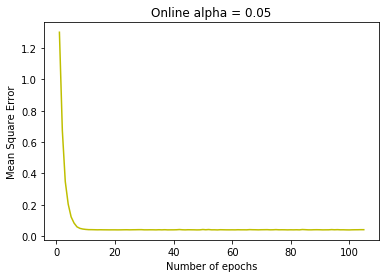

maxIter = 50000, no. of epochs = 626 , error = 0.039710517799143426


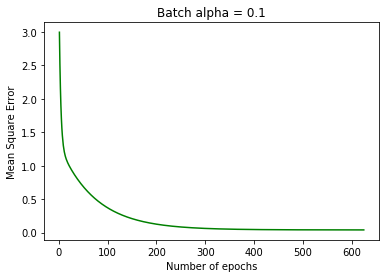

maxIter = 50000, no. of epochs = 160 , error = 0.038927317033084614


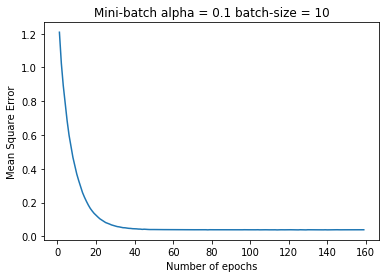

In [8]:
# ONLINE

maxIter = 50000
alpha = 0.05
error_list,w=least_squares_grad_desc(X, y, maxIter, alpha, online_epoch)
print ("maxIter = 50000, no. of epochs =", len(error_list), ", error =", error_list[-1])

plt.plot([i for i in range(len(error_list))], error_list, 'y')
plt.title('Online alpha = 0.05')
plt.xlabel('Number of epochs')
plt.ylabel('Mean Square Error')
plt.show()


# BATCH

maxIter = 50000
alpha = 0.1
error_list,w=least_squares_grad_desc(X, y, maxIter, alpha, batch_update)
print ("maxIter = 50000, no. of epochs =", len(error_list), ", error =", error_list[-1])

plt.plot([i for i in range(len(error_list))], error_list, 'g')
plt.title('Batch alpha = 0.1')
plt.xlabel('Number of epochs')
plt.ylabel('Mean Square Error')
plt.show()

# MINI-BATCH

maxIter = 50000
alpha = 0.1
error_list,w=least_squares_grad_desc(X, y, maxIter, alpha, mini_batch_update, 10)
print ("maxIter = 50000, no. of epochs =", len(error_list), ", error =", error_list[-1])

plt.plot([i for i in range(len(error_list))], error_list)
plt.title('Mini-batch alpha = 0.1 batch-size = 10')
plt.xlabel('Number of epochs')
plt.ylabel('Mean Square Error')
plt.show()

## Part 3

The data set from a regression problem can be converted into a classification problem simply by using the sign of (+ or -) as representing one of two classes. In the data set used in Part 1 and 2, you'll see the variable z that represents this binary (0 or 1) class.

Use the perceptron learning rule to solve for the coefficients {$w_1$, $w_2$, $b$} of this classification problem.   

Two warnings: First, your solution to Part 3 should require only a few lines of code changed from the code you wrote for Part 2. Second, the Perceptron algorithm will not converge if there is no exact solution to the training data. It will jitter among coefficients that all yield roughly equally good solutions.

Complete the following functions below and use them to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given functions.

In [9]:
def change_y_values(y):
    y_ = np.copy(y)
    for i in range(len(y_)):
        if y_[i] == 0:
            y_[i] = -1
    return y_

def perceptron_update(X, y, w, alpha):
    """
    One epoch of Perceptron updates (full sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    incorrect : Incorrectly classified examples
    """
    y_ = change_y_values(y)
    incorrect = 0
    
    for i in range(len(y)):
        if y_[i] * np.dot(X[i],w) < 0:
            w += alpha*y_[i]*X[i]
            incorrect += 1
    
    return w,incorrect
            
    #pass

def perceptron(X, y, maxIter, alpha):
    """
    Implements the Perceptron algorithm.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : The maximum number of iterations allowed 
    alpha : Learning Rate
    
    Returns
    -------
    w : Coefficients of the classifier
    incorrect : Incorrectly classified examples on termination
    """
    incorrect_list=[]
    w = np.random.rand(len(X[0]))
    for i in range(maxIter):
        X, y = shuffle(X, y)
        w, incorrect = perceptron_update(X, y, w, alpha)
        if i>200 and error_difference(incorrect_list[-1],incorrect):
            return w, incorrect_list
        incorrect_list.append(incorrect)
    return w,incorrect_list
    #pass

(A) Report the values of coefficients $w_1$, $w_2$, and $b$.

In [10]:
w, incorrect_list = perceptron(X, z, 1000, 0.01)
print ("w1 =", w[0])
print ("w2 =", w[1])
print ("b =", w[2])
print ("Incorrect examples:", incorrect_list[-1])

w1 = -0.17593827482606242
w2 = 0.25476933865677814
b = -0.03626547520388839
Incorrect examples: 5


(B) Make a graph of the accuracy (% correct classification) on the training set as a function of epoch.

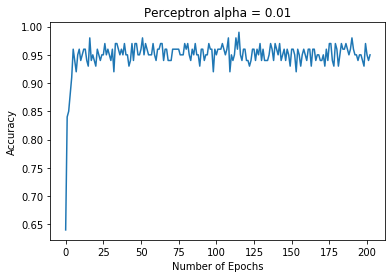

In [11]:
accuracy = 1.0 - (np.array(incorrect_list) / len(z))

plt.title("Perceptron alpha = 0.01")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.plot([i for i in range(len(incorrect_list))], accuracy)
plt.show()

## Part 4

In machine learning, we really want to train a model based on some data and then expect the model to do well on "out of sample" data. Try this with the code you wrote for Part 3:  Train the model on the first {5, 10, 25, 50, 75} examples in the data set and test the model on the final 25 examples.

Complete the following function below and use it to answer (A). 

**Note:** Please do not change the interface of the given function.

In [12]:
def classify(X, y, w):
    """
    Use this function to classify examples in the test set
    
    Parameters
    ----------
    X : Test set features
    y : Test set labels
    w : Perceptron coefficients
    
    Returns
    -------
    correct : number of correctly classified examples
    """
    correct = 0
    
    y_ = change_y_values(y)
    
    for i in range(len(y)):
        if y_[i] * np.dot(X[i],w) > 0:
            correct += 1
    
    return correct
    #pass

How does performance on the test set vary with the amount of training data? Make a bar graph showing performance for each of the different training set sizes.

[0.52, 0.72, 0.96, 0.92, 0.92]


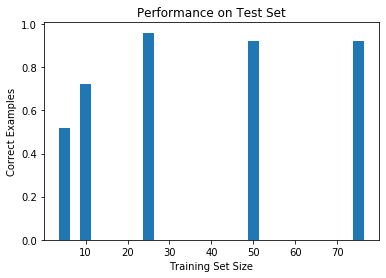

In [13]:
train_sets = [5, 10, 25, 50, 75]
correct_list = []
X_test = X[-25:]
z_test = z[-25:]
for train_set in train_sets:
    X_train = X[:train_set]
    z_train = z[:train_set]
    w, incorrect = perceptron(X_train, z_train, 1000, 0.001)
    correct = classify(X_test, z_test, w)
    correct_list.append(correct / len(z_test))
print (correct_list)
plt.bar(train_sets, correct_list, width=2.5)
plt.xlabel("Training Set Size")
plt.ylabel("Correct Examples")
plt.title("Performance on Test Set")

plt.show()